In [6]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import scipy
import progressbar

# Gravitational N-body simulation

### Problem set up and methods

A system of $N$ point-like particles on a three-dimensional domain of size $L^3$ is considered.
The state of the system at time $t$ is characterised by particle coordinates $\{ \vec q_i(t)\}$ and velosities $\{ \vec v_i(t)\}$, $i = 0,...,N-1$.


Gravitational potential of one unit-mass particle is given by
$g(\vec r) = - \frac {G}{r}$.
Potential everywhere in space can be expressed as $V(\vec r) = \rho (\vec r) \circledast g(\vec r)$, where $\rho (\vec r)$ is the mass density.

A force acting on a particle of mass $m$ is $\vec F = -\vec \nabla U = - m\vec \nabla V$ , so the accelaration is $\vec a = -\vec \nabla V$.

Leapfrog integration algorithm is used for updating particle coordinates and velocities:
\begin{equation}
\vec q_{n+1} = \vec q_{n} + \vec v_{n+ 1/2}dt; 
\end{equation}
\begin{equation}
\vec v_{n+3/2} = \vec v_{n+1/2} + \frac{\vec F_{n+ 1}}{m}dt. 
\end{equation}

The energy of the system is given by: 
\begin{equation}
E = E_{kin} + E_{pot} = \sum_{i=0}^{N-1} \frac{m_i v_i^2}{2} + \frac{1}{2}\sum_{i=0}^{N-1} m_i V(\vec q_i).
\end{equation}

Technical notes:
* All functions of $\vec r$ are disctretized and evaluated on a grid of size $npix * npix * npix$. The grid cell size $L/npix$ is chosen as the unit of length,  $L/npix$  = 1. 


* Two coordinate systems are used: one representing physical coordinates of particles, and the other representing 3D array indices/grid positions.The grid cell centers are chosen to be at integer locations, so a cell with indiсes $i,j,k$ encloses part of space $[i-1/2, i+1/2]\times[j-1/2, j+1/2]\times[k-1/2, k+1/2]$. Thus, spacial coordinates $\in [-L/2-1/2, L/2-1/2]$ are shifted by $L/2$ to get the corresponding grid position $\in [0, L-1]$.


* To avoid self forces, the potential is set to be constant for small distances $r<R$, $g(0) = -G/1 = -1 $ (softening radius is one grid cell $R = 1$, gravitational constant $G$ is set to 1). 


* Consequently, to have the potential energy of an isolated particle $=0$, a term $1/2 m$ is added to $E_{pot}$.


* Gradients are calculated using central difference.


* The constant timestep $dt$ is chosen so that the change of the fastest particle coordinates is small: $\max(\{v_{i,\alpha}\}) * dt < 1$ (cell size),  $i = 0,...,N-1$, $\alpha = x,y,z$.


* For non-periodic boundary conditions, $V(\vec r)$ and $\rho(\vec r)$ are set to be $0$ outside of the considered region of space.


### Class structure

class **Particles**:

Attributes: current state of the system and calculation parameters.

Methods:

**solve**: initially, sets up $g(r)$ (using **__Greens_function**) and allocates an array for $\rho(r)$ for chosen boundary conditions; calls **take_leapfrog_step** specified number of times, calculates energy at each moment of time, saves data (trajectories/images and energy).
    
**take_leapfrog_step**: one iteration of leapfrog integration, checks the condition on $dt$, applies boundary conditions to newly updates particle positions.
   
**get_forces**: converts spacial coordinates to integer positions on the grid, calls **get_potential**, calculates the accelaration of each particle.
   
**get_potential**: calls **get_density**, calculates $V(\vec r)$ by a convolution.
   
**get_density**: converts particle grid coordinates and masses into a density array using nearest grid point method.

In [7]:
@nb.njit()
def get_density_nb(rho, grid_pos, m, npix): 
    '''
    An auxiliary numbafied function used in Particles.get_density method.
    Iterates over particles to get the density grid.
    '''
    for i in range(grid_pos.shape[0]):
        rho[grid_pos[i,0], grid_pos[i,1], grid_pos[i,2]] += m[i]

plt.style.use('dark_background')
def display(q):
    '''
    Makes a 3D scatter plot of particle coordinates q.
    '''
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.grid(False)
    ax.xaxis.pane.set_edgecolor('white')
    ax.yaxis.pane.set_edgecolor('white')
    ax.set_xticks([])          
    ax.set_yticks([])
    ax.set_zticks([])
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    x = q[:,0]
    y = q[:,1]
    z = q[:,2]
    ax.scatter(x, y, z, s = 1, alpha = 0.1, c = 'dodgerblue')
    return fig

###################################################################################################
class Particles:
    '''
    Contains data and methods for running a single N-body gravitational simulation in 3D. 
    '''
    def __init__(self, q0, v0, m = 1.0, N = 1000, R = 1., npix = 128, dt = 0.1):
        '''
        Initialize with initial conditions:
        q0 : np.array - particle initial coordinates;
        v0 : np.array - initial velosities,
        and parameters:
        m : int/np.array - particle mass (if they are all the same) or vector of masses;
        N : int - number of particles;
        R : float - softening radius;
        npix : int - number of grid cells along each axis;
        dt : float - integration time step.
        '''
        self.N = N
        self.dim = 3
        Shape = (self.N, self.dim)
        assert q0.shape == Shape and v0.shape == Shape, "Wrong shape of input parameters."
        assert np.max(q0) < npix//2-0.5 and np.min(q0) >= -npix//2-0.5, "Particle out of the domain."
        
        self.q = q0.copy()
        self.v = v0.copy()
        self.m = np.ones(N)*m
        self.npix = npix
        self.dt = dt
        self.R = R
        self.rho = np.empty((npix, npix, npix))
        self.rho_padded = None
        self.V = np.empty((npix, npix, npix))
        self.g = None 
        self.gft = None
        self.F = np.empty((self.npix, self.npix, self.npix, self.dim))
        self.forces = np.empty(Shape)
    #______________________________________________________________________________________________    
    def __Greens_function(self, n):
        '''
        Evaluate the Green's function on a grid.
        Input: n - number of grid cells along one axis.
        Output: g - matrix of values of g(r).
        '''
        g = np.zeros((n, n, n))
        for i in range(-n//2, n//2):
            for j in range(-n//2, n//2):
                for k in range(-n//2, n//2):
                    r = np.sqrt(i**2 + j**2 + k**2)
                    if r < self.R:
                        g[i,j,k] = -1./self.R
                    else:
                        g[i,j,k] = -1./r
        return g
    #______________________________________________________________________________________________
    def get_density(self, grid_pos):
        '''
        Given discretized positions of particles, calculate the density in space.
        '''
        ## using point-like particles:
        self.rho = np.zeros((self.npix, self.npix, self.npix))
        get_density_nb(self.rho, grid_pos, self.m, self.npix)       
                    
    def get_potential(self, grid_pos, bc):
        '''
        Calculate gravitational potential in space with a convolution.
        Boundary conditions (periodic or non-periodic) are taken into account.
        '''
        self.get_density(grid_pos)
        if bc == 'periodic':
            Vft = scipy.fft.rfftn(self.rho, workers = 4)*self.gft
            self.V = scipy.fft.irfftn(Vft, workers = 4)
        if bc == 'non-periodic':
            self.rho_padded[:self.npix, :self.npix, :self.npix] = self.rho
            Vft = scipy.fft.rfftn(self.rho_padded, workers = 4)*self.gft
            self.V = scipy.fft.irfftn(Vft, workers = 4)[:self.npix, :self.npix, :self.npix].copy()
        
    #______________________________________________________________________________________________
    def get_forces(self, bc):
        '''
        Calculate the forces per unit mass (accelerations) as the gradient of the potential.
        After that, map the forces back to particles using their discretized positions on the grid.
        Boundary conditions (periodic or non-periodic) are taken into account.
        '''
        grid_pos = np.array(np.rint(self.q), dtype = np.int)+self.npix//2
        self.get_potential(grid_pos, bc)

        self.F[:,:,:,0] = (np.roll(self.V,1, axis = 0) - np.roll(self.V,-1, axis = 0))/2.
        self.F[:,:,:,1] = (np.roll(self.V,1, axis = 1) - np.roll(self.V,-1, axis = 1))/2.
        self.F[:,:,:,2] = (np.roll(self.V,1, axis = 2) - np.roll(self.V,-1, axis = 2))/2.

        if bc == 'non-periodic':
            #axis 0
            self.F[0, :,:, 0] = -self.V[1,:,:]/2.
            self.F[-1, :,:, 0] = self.V[-2, :,:]/2
            # axis 1
            self.F[:, 0,:, 1] = -self.V[:,1,:]/2.
            self.F[:, -1, :,1] = self.V[:,-2,:]/2
            # axis 2
            self.F[:,:, 0, 2] = -self.V[:,:,1]/2.
            self.F[:,:, -1, 2] = self.V[:,:,-2]/2
        for i, (y,x,z) in enumerate(grid_pos):
            self.forces[i, :] = self.F[y,x,z,:]
    #_______________________________________________________________________________________________    
    def take_leapfrog_step(self, bc, dt):
        '''
        One integration step.
        A warning is produced if max(v)*dt is greater that the cell size; 
        a shorter dt should be chosen then.
        '''
        CFL = np.max(np.abs(self.v))*dt
        if CFL > 1.:
            print('Warning: max v*dt/dx =',CFL)
            
        self.q += self.v*dt
        if bc == 'periodic':
            self.q[self.q>=self.npix//2-0.5] -= self.npix
            self.q[self.q< -self.npix//2-0.5] += self.npix
        else:
            if np.any(self.q>=self.npix//2-0.5) or np.any(self.q< -self.npix//2-0.5):
                out_ind = np.where(np.any(self.q >= self.npix//2-0.5, axis = 1))
                self.q = np.delete(self.q, out_ind, axis = 0)
                self.v = np.delete(self.v, out_ind, axis = 0)
                self.m = np.delete(self.m, out_ind, axis = 0)
                self.forces = np.delete(self.forces, out_ind, axis = 0)
                self.N -= len(out_ind[0])
                
                out_ind = np.where(np.any(self.q < -self.npix//2-0.5, axis = 1)) 
                self.q = np.delete(self.q, out_ind, axis = 0)
                self.v = np.delete(self.v, out_ind, axis = 0)
                self.m = np.delete(self.m, out_ind, axis = 0)
                self.forces = np.delete(self.forces, out_ind, axis = 0)
                self.N -= len(out_ind[0])  
        self.get_forces(bc)
        self.v += self.forces*dt
    #____________________________________________________________________________________________________________    
    def solve(self, bc = 'periodic', nsteps = 5000, dt = 0.1, save_trajectory = False, saving_dir = None, T = 10):
        '''
        Run a simulation with parameters:
        bc : string - boundary conditions, 'periodic' or 'non-periodic';
        nsteps : int - number of integration steps;
        dt : float - integration time step;
        save_trajectory : bool- if True and number of particles N<=5, saves coordinates into trajectory array;
        saving_dir : string - if specified, frames (see display function) will be saved into the directory;
        T : int - temporal spacing (in integration steps) between the saved frames.
        
        Output:
        E_tot : np.array - array of energy values at each time step;
        trajectory (if applicable) : np.array - particle coordinates at each time step.
        '''
        assert bc in ['periodic', 'non-periodic'], 'Specify valid boundary conditions.'
        E_pot = 0.
        E_kin_old = 0.
        E_kin = 0.
        E_tot = np.zeros(nsteps)
        if save_trajectory == True:
            assert self.N <= 5, "For many particles, save to files."
            trajectory = np.zeros((nsteps, self.N*self.dim))
        
        if bc == 'periodic':
            self.g = self.__Greens_function(self.npix)
            self.gft = scipy.fft.rfftn(self.g, workers = 4)
        if bc == 'non-periodic':
            self.g = self.__Greens_function(self.npix*2)
            self.gft = scipy.fft.rfftn(self.g, workers = 4)
            self.rho_padded = np.zeros((self.npix*2, self.npix*2, self.npix*2))
        
        self.get_forces(bc)
        # get v_1/2 for the leapfrog:
        self.v += self.forces*0.5*dt  
        E_kin = 1./2*np.sum(self.m*(np.sum(self.v**2, axis = 1)))
        
        for istep in progressbar.progressbar(range(nsteps)):
            if save_trajectory == True:
                trajectory[istep, :] = self.q.flatten()
            if saving_dir is not None:
                if istep % T == 0:
                    fig = display(self.q)
                    fig.savefig(saving_dir+'q'+str(istep*dt)+'.png', bbox_inches='tight')
                    plt.close(fig)        
            E_pot = 1/2.*np.sum(self.rho*self.V)+np.sum(self.m)/2.
            E_kin_old = E_kin
            E_kin = 1./2*np.sum(self.m*(np.sum(self.v**2, axis = 1)))
            E_tot[istep] = E_pot + 1/2.*(E_kin_old + E_kin)
            
            self.take_leapfrog_step(bc, dt)    
        if save_trajectory == True:
            return E_tot, trajectory
        return E_tot

### Part 1) One particle

In [5]:
N = 1
q1 = np.zeros((1,3))
v1 = np.zeros((1,3))
part1 = Particles(q1, v1, 1., N, npix = 64)
E1, trajectory = part1.solve(dt = 1, nsteps = 100, save_trajectory = True)

100% (100 of 100) |######################| Elapsed Time: 0:00:02 Time:  0:00:02


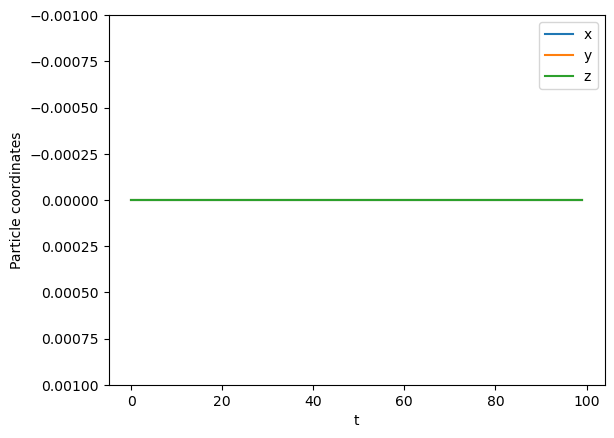

In [6]:
plt.style.use('default')
plt.plot(trajectory[:,0], label = 'x')
plt.plot(trajectory[:,1], label = 'y')
plt.plot(trajectory[:,2], label = 'z')
plt.ylim(0.001,-0.001)
plt.legend()
plt.xlabel('t')
plt.ylabel('Particle coordinates')
plt.show()

One particle with zero initial velocity stays at rest.

### Part 2) Two particles on a circular orbit

Two circular orbits in perpendicular planes have been simulated to check all directions in 3D:

In [7]:
N = 2
D = 20.
m = 1.
v_circular = np.sqrt(m**2/(2*m)/D)
nsteps = 2000
dt = 1

q2a = np.array([[D/2.,0., 0.],[-D/2.,0.,0.]])
v2a = np.array([[0., v_circular, 0.],[0., -v_circular, 0.]])

part2a = Particles(q2a, v2a, m, N, npix = 64)
E2a, trajectories_a = part2a.solve(nsteps = nsteps, dt = dt, save_trajectory = True)

q2b = np.array([[0.,-D/2.,0.],[0.,D/2.,0.]])
v2b = np.array([[0.,0., v_circular],[0.,0., -v_circular]])

part2b = Particles(q2b, v2b, m, N, npix = 64)
E2b, trajectories_b = part2b.solve(nsteps = nsteps, dt = dt, save_trajectory = True)

100% (2000 of 2000) |####################| Elapsed Time: 0:00:48 Time:  0:00:48
100% (2000 of 2000) |####################| Elapsed Time: 0:00:48 Time:  0:00:48


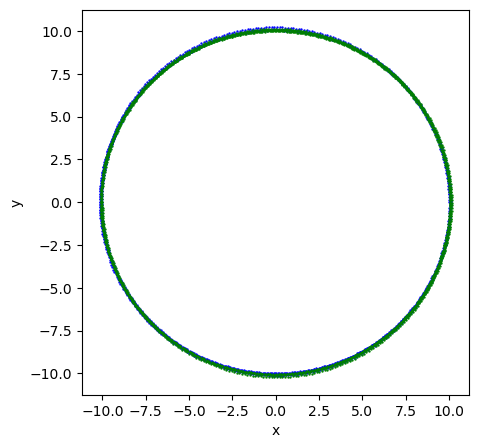

In [19]:
plt.figure(figsize = (5,5))
plt.scatter(trajectories_a[:,0], trajectories_a[:,1], color = 'b', marker = '.', s = 2)
plt.scatter(trajectories_a[:,3], trajectories_a[:,4], color = 'g', marker = '.', s = 2)
plt.xlabel('x'); plt.ylabel('y')
plt.show()

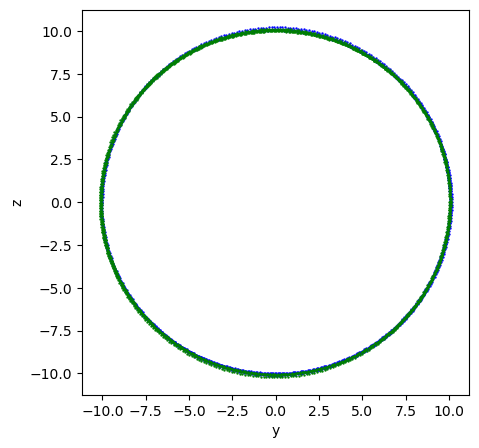

In [20]:
plt.figure(figsize = (5,5))
plt.scatter(trajectories_b[:,1], trajectories_b[:,2], color = 'b', marker = '.', s = 2)
plt.scatter(trajectories_b[:,4], trajectories_b[:,5], color = 'g', marker = '.', s = 2)
plt.xlabel('y'); plt.ylabel('z')
plt.show()

Plot one component of coordinate vector to see that more than one orbital period has been covered:

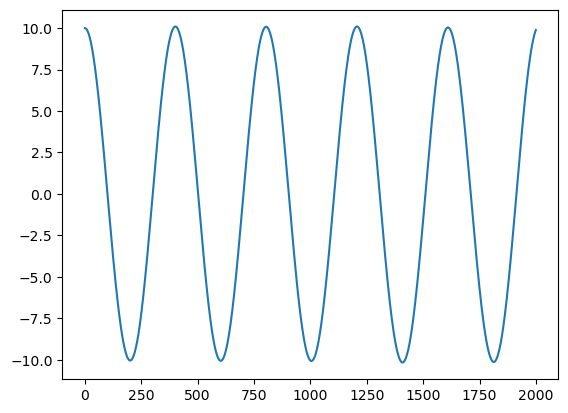

In [22]:
plt.plot(trajectories_a[:,0])
plt.show()

### Part 3) Uniform initial density

#### a) Periodic boundary conditions

In [57]:
N = 10**5
q = np.random.uniform(-64., 64., size=(N,3))-0.5
v = np.zeros((N,3))
m = 1.
part3a = Particles(q, v, m, N)
nsteps = 5000
dt = 0.002
E3a = part3a.solve(bc = 'periodic', nsteps = nsteps, dt = dt, saving_dir = 'Nbody/part3a_3/')

100% (5000 of 5000) |####################| Elapsed Time: 0:50:17 Time:  0:50:17


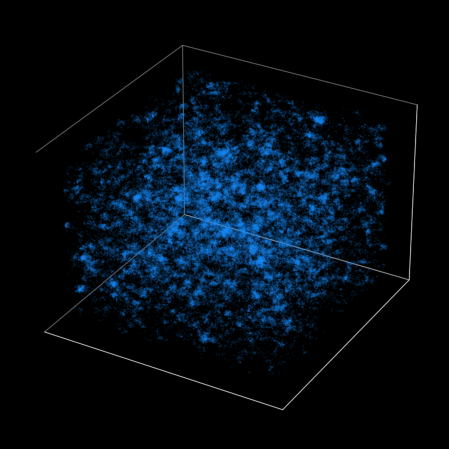

In [19]:
part3a_example = plt.imread('Nbody/part3a_3/q4.1.png')
plt.figure(figsize = (8,8))
plt.imshow(part3a_example)
plt.axis('off')
plt.show()

With periodic boundary conditions, clusters start forming uniformly in space and they gradually increase in size.

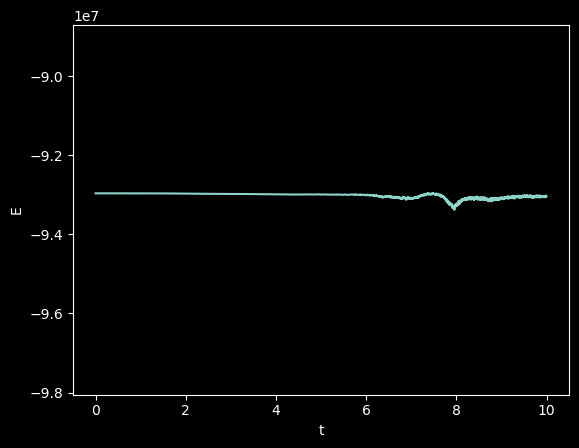

Fluctuations of energy with periodic boundary conditions: 0.000268 %


In [63]:
E3a_fluct = np.sqrt(np.std(E3a))/np.mean(np.abs(E3a))
plt.plot(np.array(range(5000))*0.002, E3a)
plt.ylim(np.min(E3a)*1.05, np.min(E3a)*0.95)
plt.xlabel('t')
plt.ylabel('E')
plt.show()
print('Fluctuations of energy with periodic boundary conditions:', '%.6f'% (E3a_fluct*100), '%')

The energy is conserved really well, the fluctuations are just a bit larger at later times, when very dense regions start forming. 

#### b) Non-periodic boundary conditions

In [77]:
N = 10**5
q = np.random.uniform(-64., 64., size=(N,3))-0.5
v = np.zeros((N,3))
m = 1.
nsteps = 2000
dt = 0.002
part3b = Particles(q, v, m, N)
E3b = part3b.solve(bc = 'non-periodic', nsteps = nsteps, dt = dt, saving_dir = 'Nbody/part3b_3/')

100% (2000 of 2000) |####################| Elapsed Time: 0:34:40 Time:  0:34:40


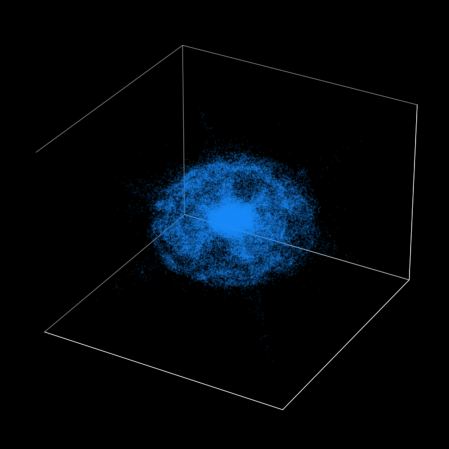

In [17]:
part3b_example = plt.imread('Nbody/part3b_3/q2.82.png')
plt.figure(figsize = (8,8))
plt.imshow(part3b_example)
plt.axis('off')
plt.show()

With non-periodic boundary conditions, all the particles gravitate towards the center and the system collapses.

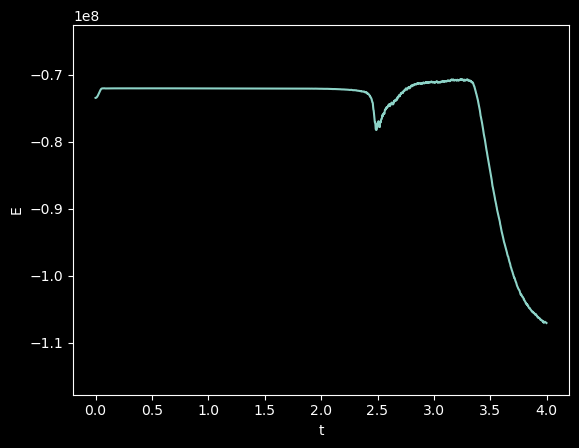

Fluctuations of energy with non-periodic boundary conditions: 0.001404 %


In [86]:
E3b_fluct = np.sqrt(np.std(E3b[:1500]))/np.mean(np.abs(E3b[:1500]))
plt.plot(np.array(range(2000))*0.002, E3b)
plt.ylim(np.min(E3b)*1.1, np.min(E3b[:1500])*0.8)
plt.xlabel('t')
plt.ylabel('E')
plt.show()
print('Fluctuations of energy with non-periodic boundary conditions:', '%.6f'% (E3b_fluct*100), '%')

In [88]:
print((part3b.N-N)/N)

-0.29491


The energy is conserved well until the formation of the dense core which leads to some particles being ejected from the system. By end of the simulation, the system has lost 30% of its mass. Energy fluctuation has been calculated for $t$ from $0$ to $3$.

### Part 4) $k^{-3}$ density fluctuations
Firstly, set up initial conditions with density fluctuations described by the scale-invariant power spectrum. The initial positions of $N$ particles are then sampled from the resulting density distribution using rejection method.

<ipython-input-107-9d29f3caf59d>:5: RuntimeWarning: divide by zero encountered in true_divide
  Pk = (1./(kx**2 + ky**2 + kz**2)**(3/2))


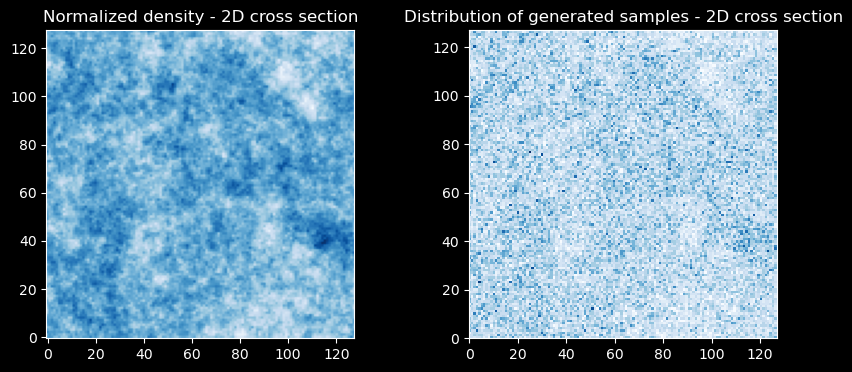

In [107]:
np.random.seed(12345)
npix = 128
freqs = scipy.fft.fftfreq(npix, d=1)
kx, ky, kz = np.meshgrid(freqs, freqs, freqs)
Pk = (1./(kx**2 + ky**2 + kz**2)**(3/2))
Pk[0,0,0] = 0.
noise = np.random.randn(npix, npix, npix)
noise_ft = scipy.fft.fftn(noise)
fluctuations = np.real(scipy.fft.ifftn(np.sqrt(Pk)*noise_ft))
density = (fluctuations-np.min(fluctuations))/(np.max(fluctuations)-np.min(fluctuations))

N = 10**5
nsamples = 2*10**7
q_trial = np.random.randint(-64, 64, (nsamples, 3))
prob = np.random.random(nsamples)
q_accepted = q_trial[prob<=density[q_trial[:,0]+64, q_trial[:,1]+64, q_trial[:,2]+64]]

plane = q_accepted[q_accepted[:,2] == 0]
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,4))
ax1.imshow(density[:,:,64], cmap = 'Blues', origin = 'lower')
ax1.set_title('Normalized density - 2D cross section')
ax2.hist2d(plane[:,1]+64, plane[:,0]+64, [128,128], cmap = 'Blues')
ax2.set_aspect('equal')
ax2.set_title('Distribution of generated samples - 2D cross section')
plt.show()

q_accepted = np.array(q_accepted[:N, :], dtype = float)

In [56]:
v = np.zeros((N,3))
m = 1.
part4 = Particles(q_accepted, v, m, N)
nsteps = 5000
dt = 0.002
E4 = part4.solve(bc = 'periodic', nsteps = nsteps, dt = dt, saving_dir = 'Nbody/part4_1/')

100% (5000 of 5000) |####################| Elapsed Time: 0:49:13 Time:  0:49:13


In [108]:
# another run with a different random seed for density generation:
v = np.zeros((N,3))
m = 1.
part4_2 = Particles(q_accepted, v, m, N)
nsteps = 3000
dt = 0.002
E4_2 = part4_2.solve(bc = 'periodic', nsteps = nsteps, dt = dt, saving_dir = 'Nbody/part4_2/')

100% (3000 of 3000) |####################| Elapsed Time: 0:29:47 Time:  0:29:47


Alternatively, sample particle coordinates from a uniform distribution and choose particle mass based on the corresponding density value in that cell:

In [113]:
N = 10**5
q4 = np.random.randint(-64, 64, (N, 3))
masses = density[q4[:,0]+64, q4[:,1]+64, q4[:,2]+64]*2
q4 = q4.astype(float)
v = np.zeros((N,3))
nsteps = 3000
dt = 0.002
part4_3 = Particles(q4, v, masses, N)
E4_3 = part4_3.solve(bc = 'periodic', nsteps = nsteps, dt = dt, saving_dir = 'Nbody/part4_3/')

100% (3000 of 3000) |####################| Elapsed Time: 0:29:37 Time:  0:29:37


The animations produced by the two approaches are similar given that the same generated density is used. 

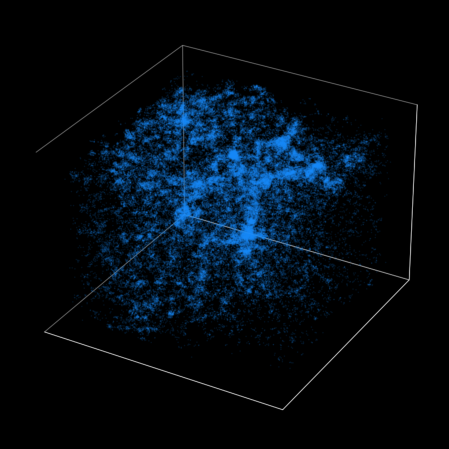

In [16]:
part4_example = plt.imread('Nbody/part4_2/q3.7.png')
plt.figure(figsize = (8,8))
plt.imshow(part4_example)
plt.axis('off')
plt.show()

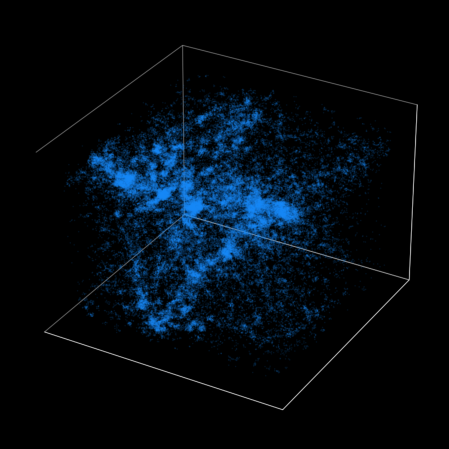

In [18]:
part4_another_example = plt.imread('Nbody/part4_1/q3.88.png')
plt.figure(figsize = (8,8))
plt.imshow(part4_another_example)
plt.axis('off')
plt.show()

With the cosmological initial conditions, large-scale structures are formed in the system.

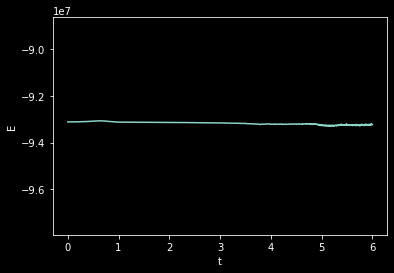

Fluctuations of energy: 0.000250 %


In [10]:
E4_2_fluct = np.sqrt(np.std(E4_2))/np.mean(np.abs(E4_2))
plt.plot(np.array(range(3000))*0.002, E4_2)
plt.ylim(np.min(E4_2)*1.05, np.min(E4_2)*0.95)
plt.xlabel('t')
plt.ylabel('E')
plt.show()
print('Fluctuations of energy:', '%.6f'% (E4_2_fluct*100), '%')

In simulations for Part 4 energy is also conserved.